## Todo - visualization solutions
- plot categorical (one-by-one)
- plot categorical (deep downsampling)

In [1]:
import json
import h5py
import tqdm
import datetime
import time
import pandas as pd
import numpy as np
import collections

import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd2/fangming/projects/SingleCellRoutines')

import __init__plots
importlib.reload(__init__plots)
from __init__plots import *

import snmcseq_utils
importlib.reload(snmcseq_utils)

import utils
importlib.reload(utils)

import datashader as ds
import colorcet

import powerplot
importlib.reload(powerplot)

import _powerplot_vizgen_merfish
importlib.reload(_powerplot_vizgen_merfish)
from _powerplot_vizgen_merfish import *

In [2]:
today = datetime.date.today()
figures = '../figures/{}_{{}}'.format(today)
results = '../data/{}_{{}}'.format(today)
figures, results

('../figures/2021-07-13_{}', '../data/2021-07-13_{}')

# read in processed data
- cell metadata
- cell gene matrix (normalized)
- cell clusters and umap
- palette and other metadata

In [3]:
# palette as json
file = '../data/palette.json'
with open(file, 'r') as f:
    palette = json.load(f)
palette

{'Slice1_Replicate1': [0.19215686274509805,
  0.5098039215686274,
  0.7411764705882353],
 'Slice1_Replicate2': [0.4196078431372549,
  0.6823529411764706,
  0.8392156862745098],
 'Slice1_Replicate3': [0.6196078431372549,
  0.792156862745098,
  0.8823529411764706],
 'Slice2_Replicate1': [0.9019607843137255,
  0.3333333333333333,
  0.050980392156862744],
 'Slice2_Replicate2': [0.9921568627450981,
  0.5529411764705883,
  0.23529411764705882],
 'Slice2_Replicate3': [0.9921568627450981,
  0.6823529411764706,
  0.4196078431372549],
 'Slice3_Replicate1': [0.19215686274509805,
  0.6392156862745098,
  0.32941176470588235],
 'Slice3_Replicate2': [0.4549019607843137,
  0.7686274509803922,
  0.4627450980392157],
 'Slice3_Replicate3': [0.6313725490196078,
  0.8509803921568627,
  0.6078431372549019]}

In [4]:
!ls ../data/*.tsv.gz

../data/clustering_embedding_S1R1_S1R2_S1R3_S2R1_S2R2_S2R3_S3R1_S3R2_S3R3_2021-05-22.tsv.gz
../data/clustering_embedding_S1R2_2021-05-22.tsv.gz
../data/clustering_embedding_S2R1_2021-05-22.tsv.gz
../data/clustering_embedding_S2R1_S1R2_2021-05-22.tsv.gz
../data/clustering_embedding_Slice1_Replicate2_2021-05-18.tsv.gz
../data/clustering_embedding_Slice2_Replicate1_2021-05-15.tsv.gz
../data/clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1_2021-06-02.tsv.gz
../data/clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1hemibrainsections_2021-06-04.tsv.gz
../data/clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1hemibrainsections_2021-06-05.tsv.gz


In [5]:
f = '../data/clustering_embedding_S1R1_S1R2_S1R3_S2R1_S2R2_S2R3_S3R1_S3R2_S3R3_2021-05-22.tsv.gz'
clsts = pd.read_csv(f, sep='\t').set_index('cell')
clsts['cluster_cat'] = pd.Categorical(clsts['cluster']) #.astype
print(clsts.shape)
clsts.head()

(692682, 5)


cluster    umap_1     umap_2  \
cell                                                                   
110883424764611924400221639916314253469     C14  1.417047   9.138863   
135188247894899244046039873973964001182     C14  1.260269   8.663673   
164766962839370328502017156371562646881     C14 -0.179721  10.929612   
165747897693809971960756442245389760838     C14  0.770016  10.161936   
260943245639750847364278545493286724628     C14  0.422456  10.411513   

                                                    sample cluster_cat  
cell                                                                    
110883424764611924400221639916314253469  Slice1_Replicate1         C14  
135188247894899244046039873973964001182  Slice1_Replicate1         C14  
164766962839370328502017156371562646881  Slice1_Replicate1         C14  
165747897693809971960756442245389760838  Slice1_Replicate1         C14  
260943245639750847364278545493286724628  Slice1_Replicate1         C14

In [6]:
input = '../data/processed_vizgen_merfish_may22_2021.hdf5'
samples = [
    'Slice1_Replicate1',
    'Slice1_Replicate2',
    'Slice1_Replicate3',
    
    'Slice2_Replicate1',
    'Slice2_Replicate2',
    'Slice2_Replicate3',
    
    'Slice3_Replicate1',
    'Slice3_Replicate2',
    'Slice3_Replicate3',
]

samples_shortname = "_".join([
    sample.replace('Slice', 'S').replace('_Replicate', 'R')
    for sample in samples
])

for sample in samples:
    gmat = []
    meta = []
    for sample in samples:
        _gmat = pd.read_hdf(input, 'mat_'+sample)
        gmat.append(_gmat)
        _meta = pd.read_hdf(input, 'meta_'+sample)
        _meta['sample'] = sample 
        meta.append(_meta)
gmat = pd.concat(gmat)
meta = pd.concat(meta)


In [7]:
# informations
thedata = clsts.drop('sample', axis=1).join(meta) #.join(clsts)
genes = gmat.columns
thedatagmat = thedata.join(gmat)
print(len(genes), gmat.shape, thedata.shape)

483 (692682, 483) (692682, 17)


### Run gene viz

  0%|          | 0/1 [00:00<?, ?it/s]

../figures/2021-07-13_9slices_Slc17a7.png


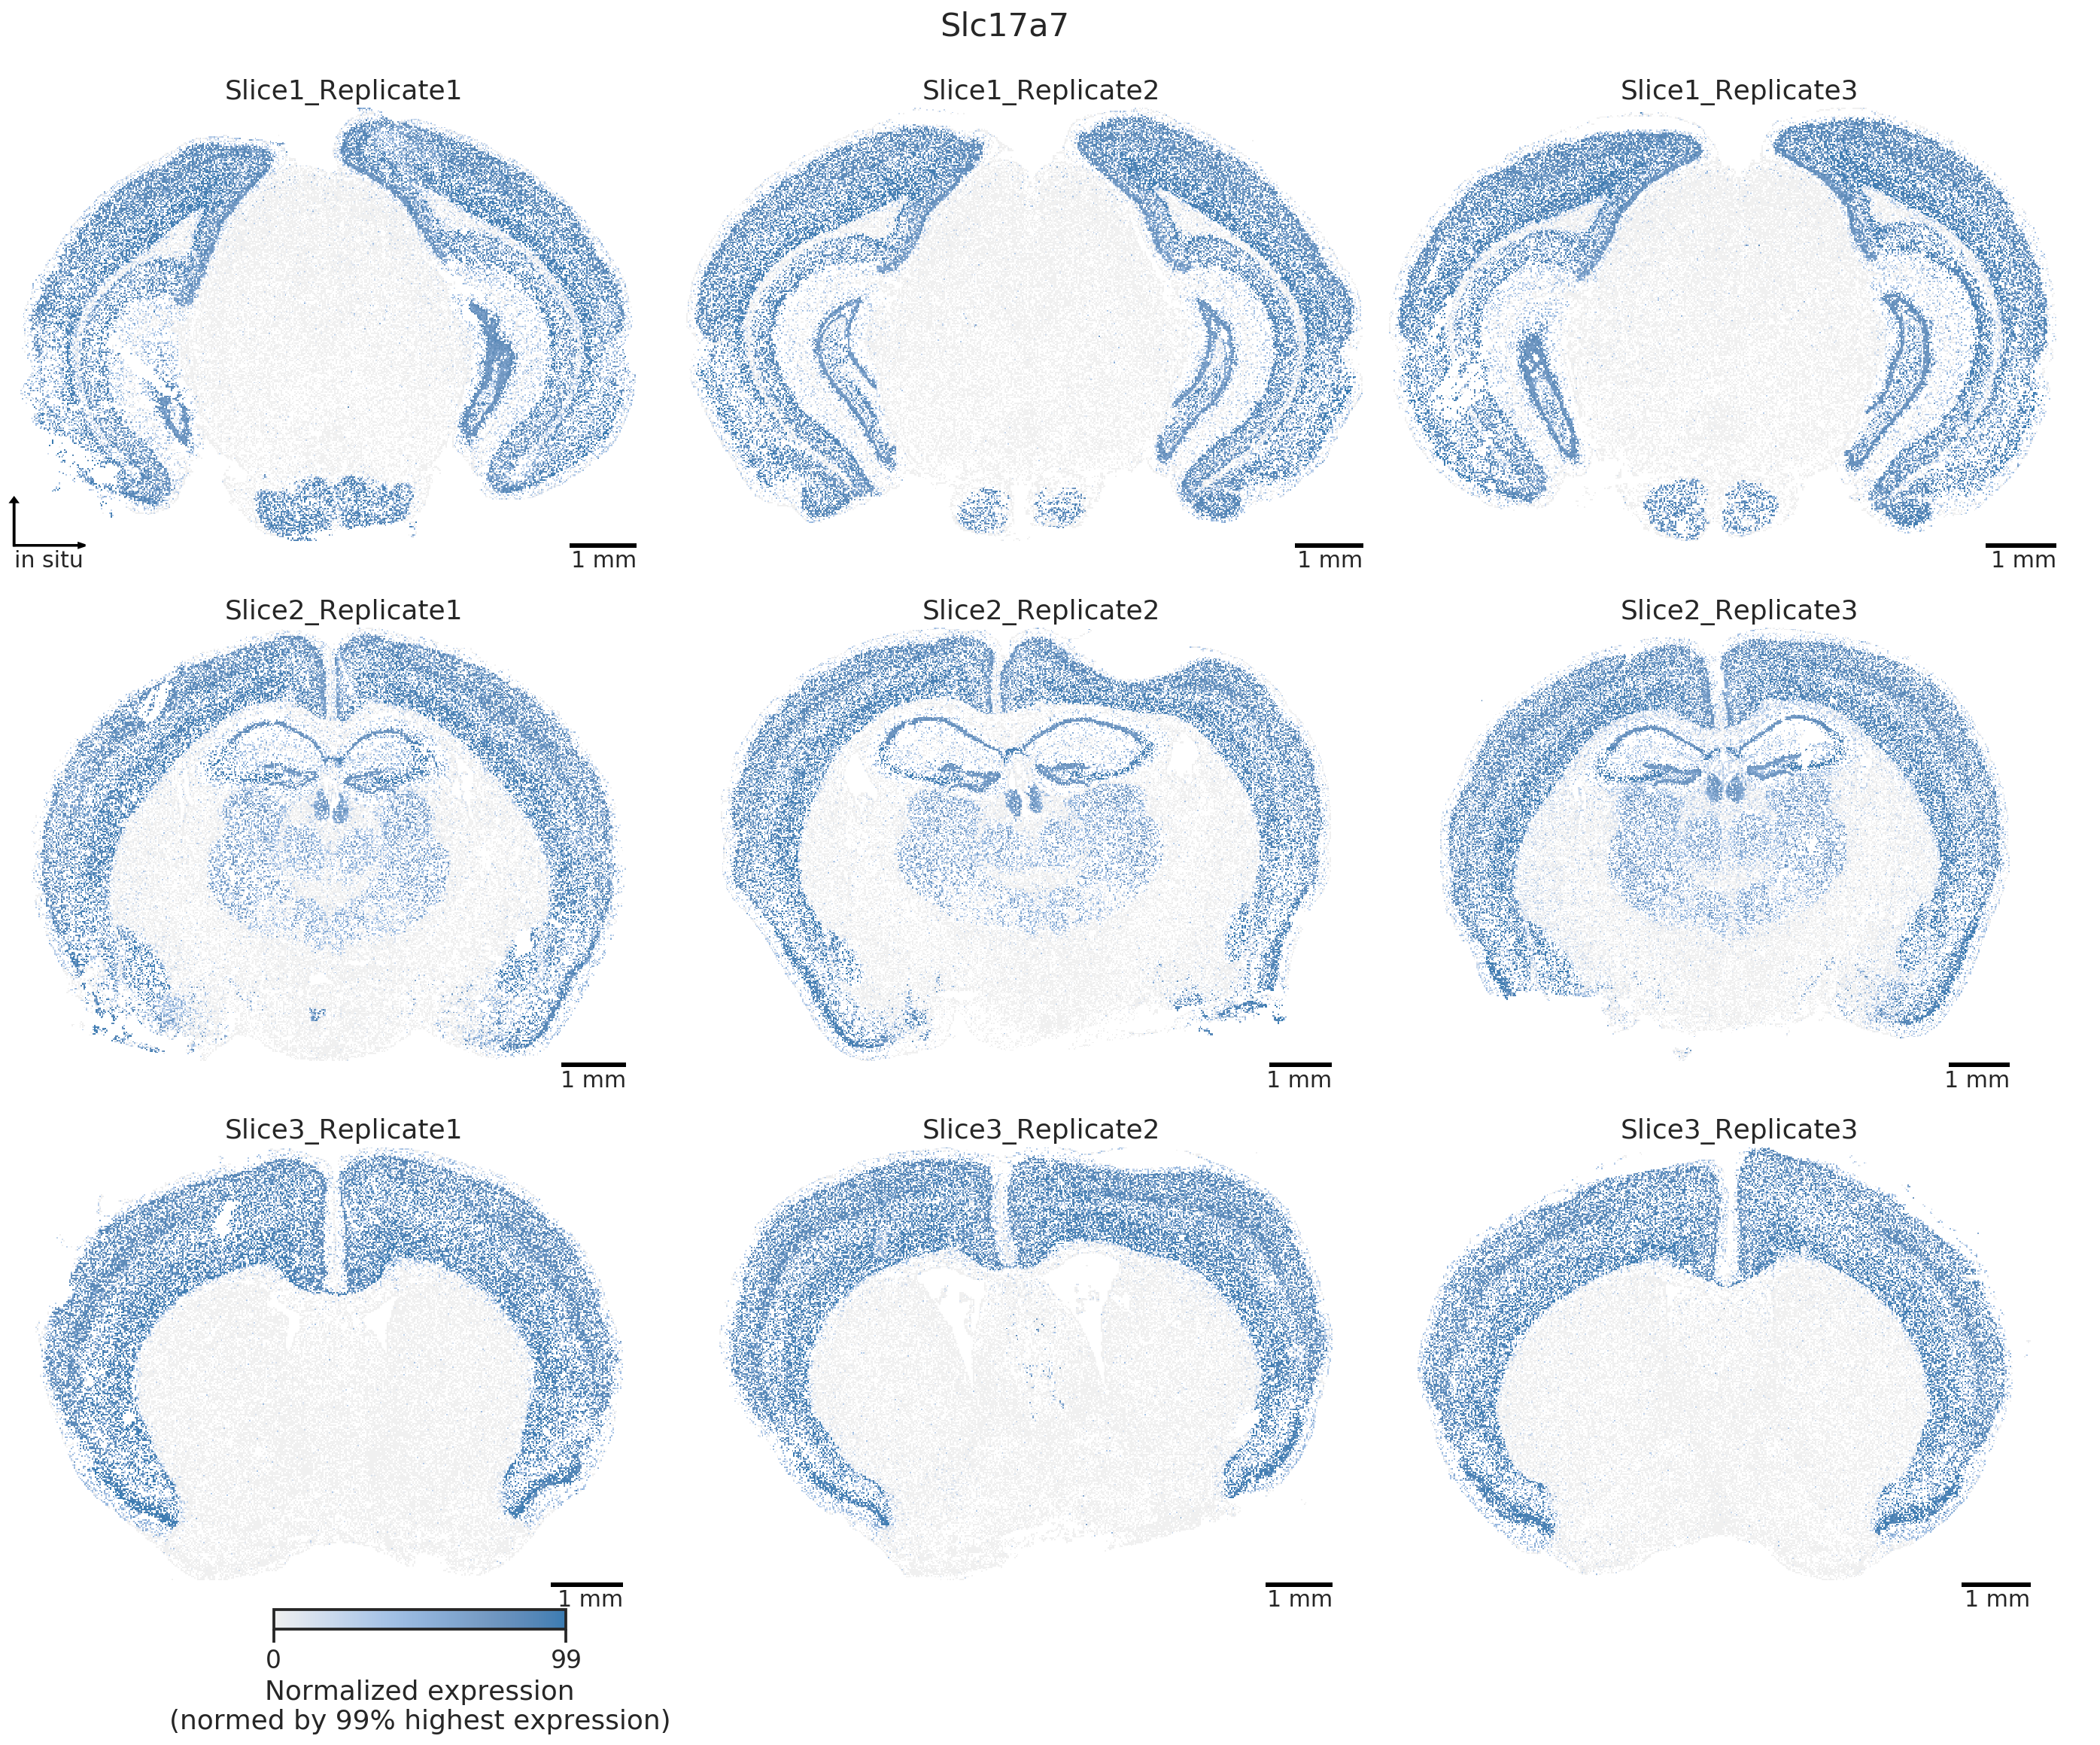

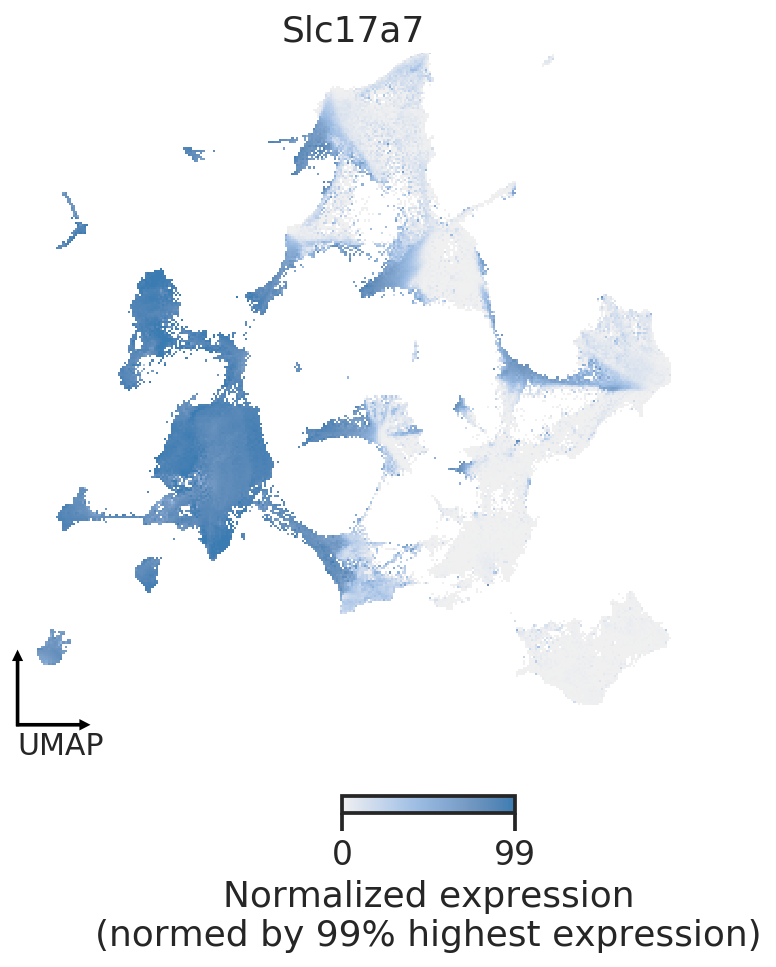

  0%|          | 0/1 [00:17<?, ?it/s]

../figures/2021-07-13_9slices_UMAP_Slc17a7.png


In [8]:
# run genes view
selected_genes = ['Slc17a7']
for gene in tqdm.tqdm(selected_genes):
    # insitu 
    x, y, hue = 'x', 'y', gene
    output = figures.format("9slices_"+gene+".png")
    
    fig_plot_gene_insitu_routine(
        thedatagmat, samples, x, y, hue, 
#         output=output, 
#         close=True,
        output='', 
        close=False,
        )
    print(output)
    
    # umap
    x, y, hue = 'umap_1', 'umap_2', gene
    output = figures.format("9slices_UMAP_"+gene+".png")
    
    fig_plot_gene_umap_routine(
        thedatagmat, x, y, hue, 
#         output=output,
#         close=True,
        output='',
        close=False,
        )
    print(output)
    break

### Run cluster viz (combined)

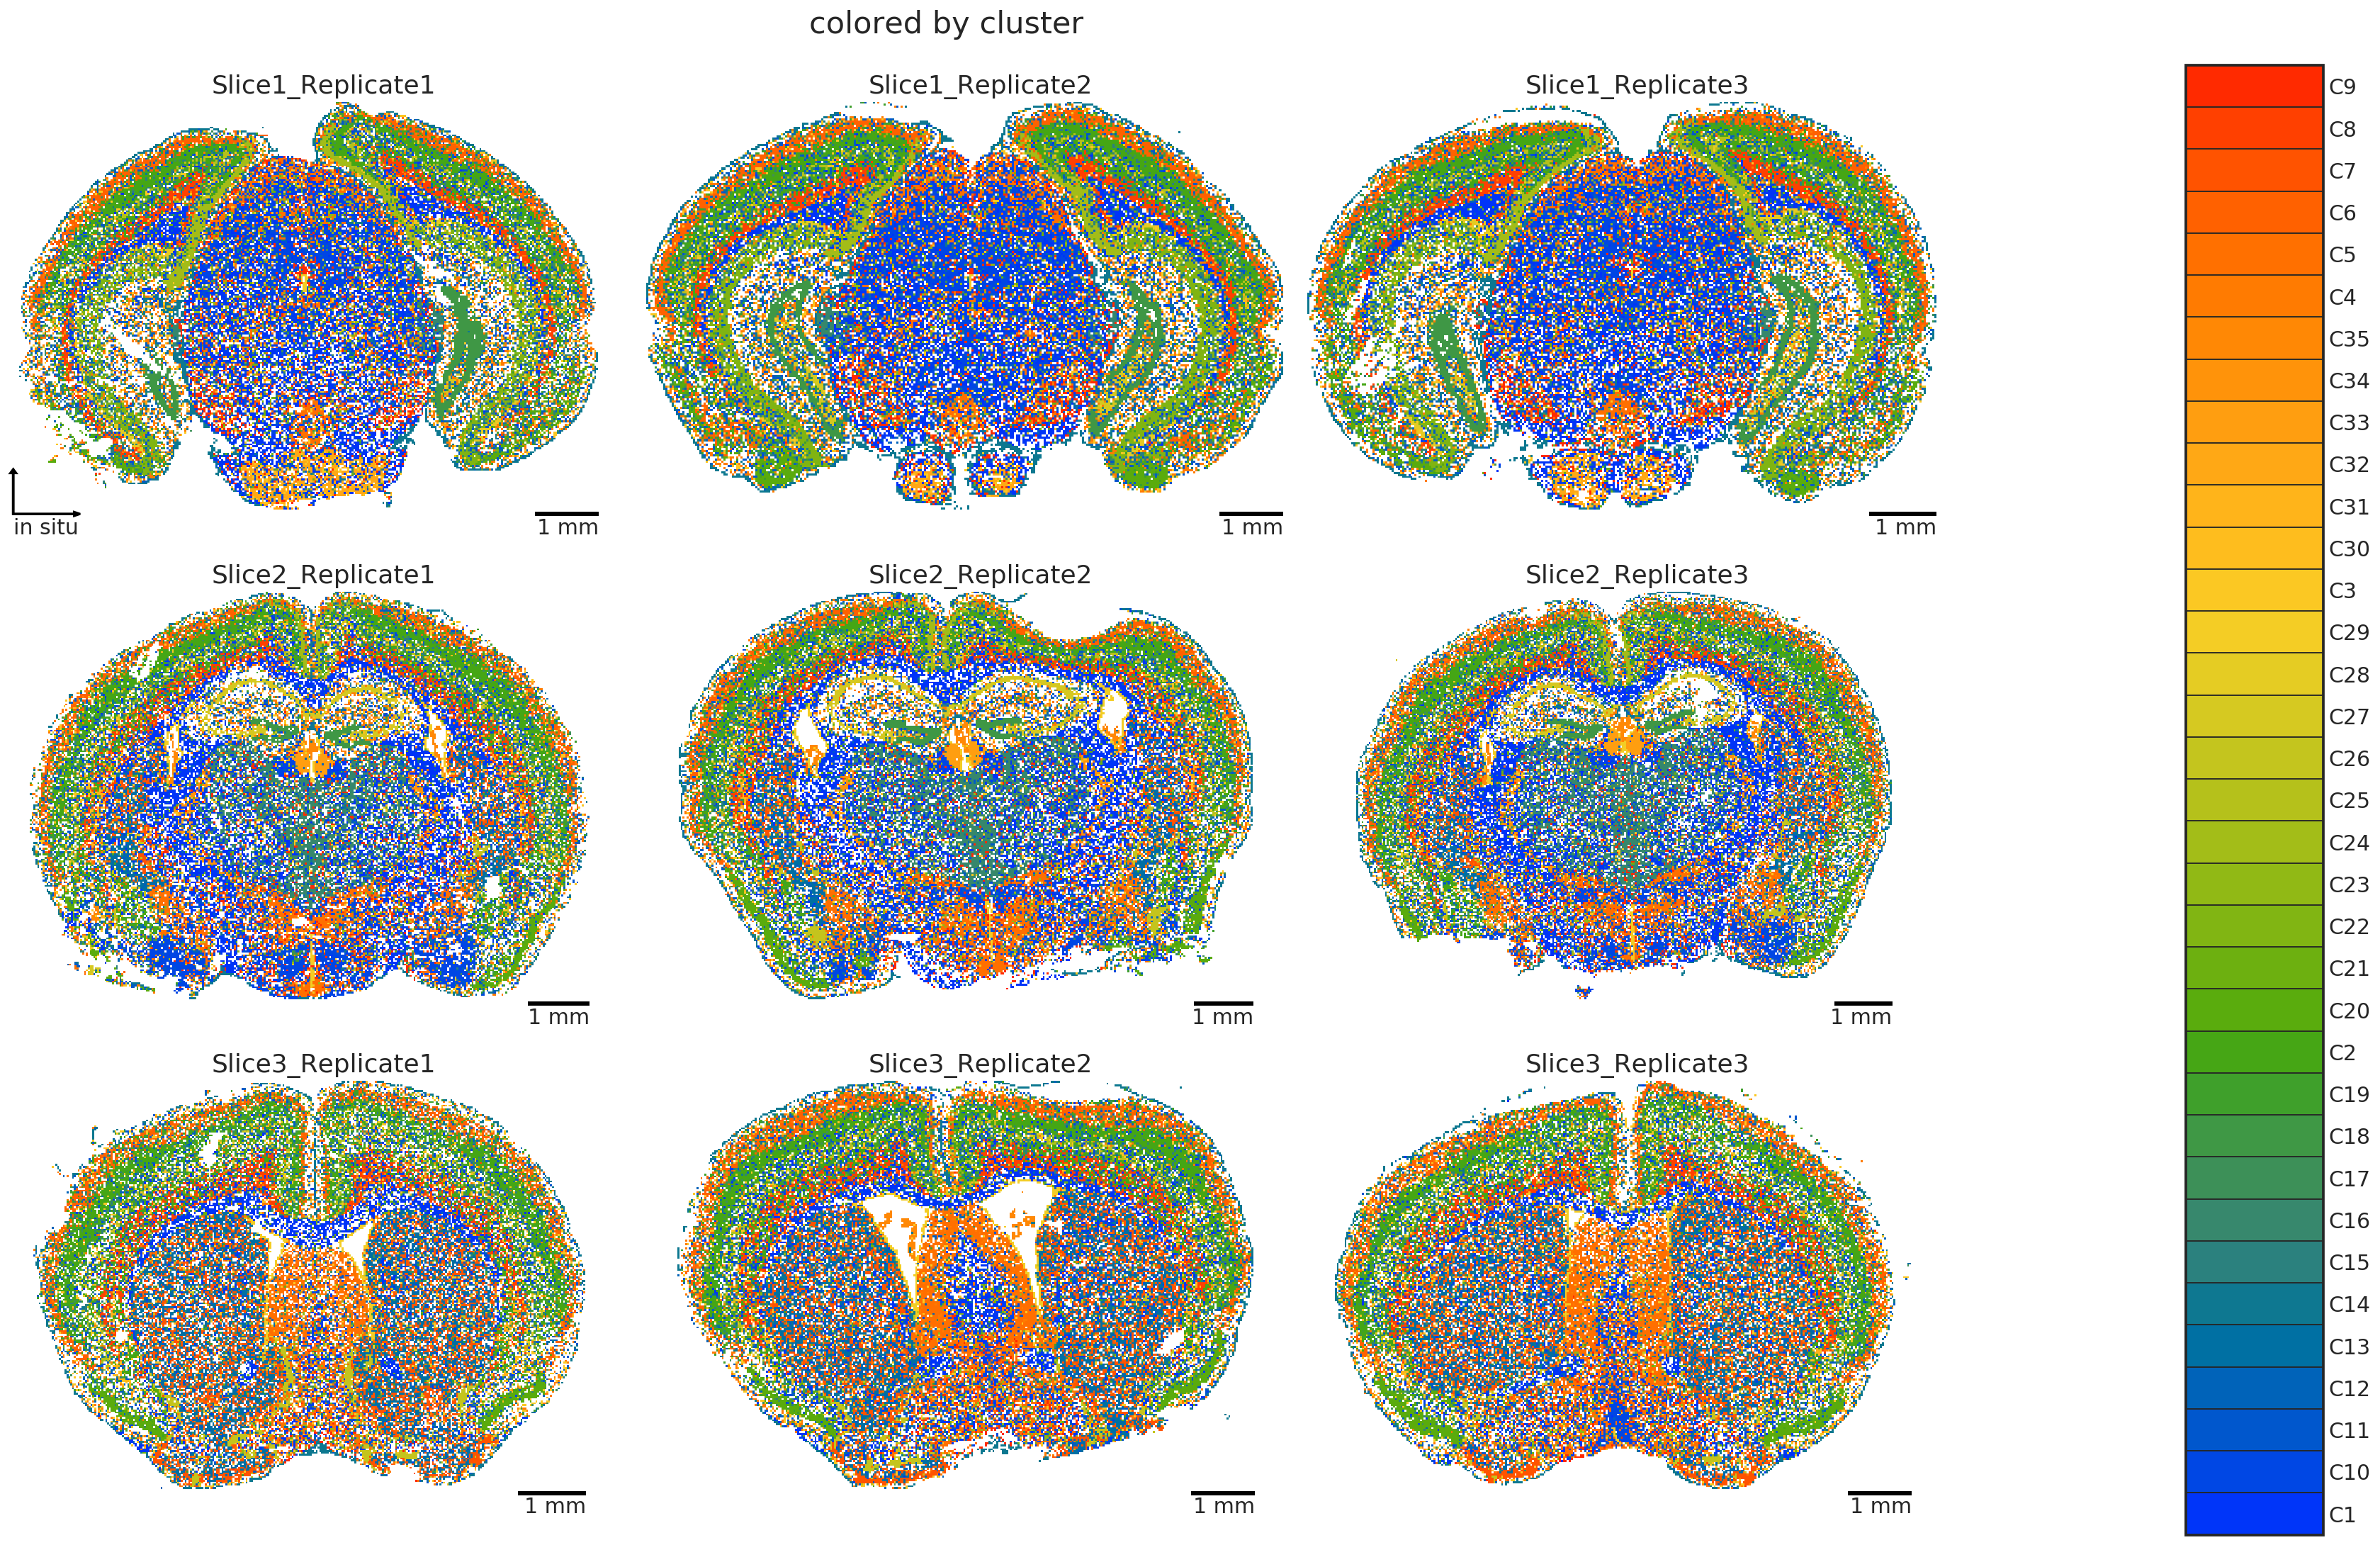

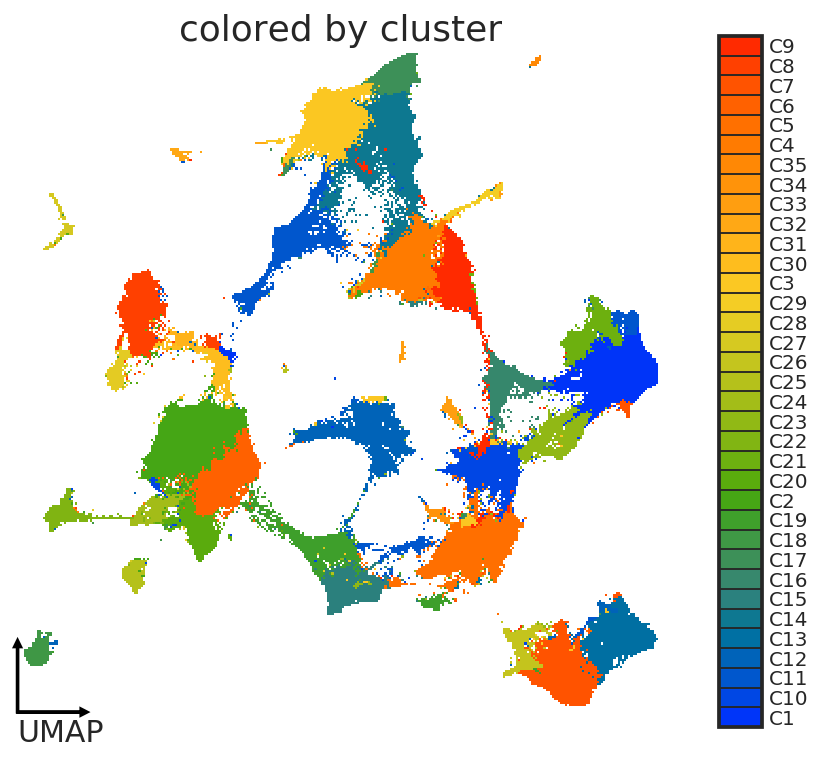

In [9]:
clusters = np.sort(thedata['cluster_cat'].cat.categories.values)
clstcolors_obj = powerplot.CategoricalColors(clusters)

# agg data for each sample
x, y, hue = 'x', 'y', 'cluster_cat'
suptitle = 'colored by cluster' 
output = figures.format("9slices_insitu_allclsts"+".png")
close = False
    
fig_plot_cluster_insitu_routine(
    thedata, samples, x, y, hue,
    clstcolors_obj,
    suptitle=suptitle,
    close=close,
    output=output, 
    ) 

# plot all clusters UMAP
x, y, hue = 'umap_1', 'umap_2', 'cluster_cat'
title = 'colored by cluster' 
output = figures.format("9slices_umap_allclsts"+".png")
close = False
fig_plot_cluster_umap_routine(
    thedata, x, y, hue,
    clstcolors_obj,
    title=title,
    close=close,
    output=output,
    )

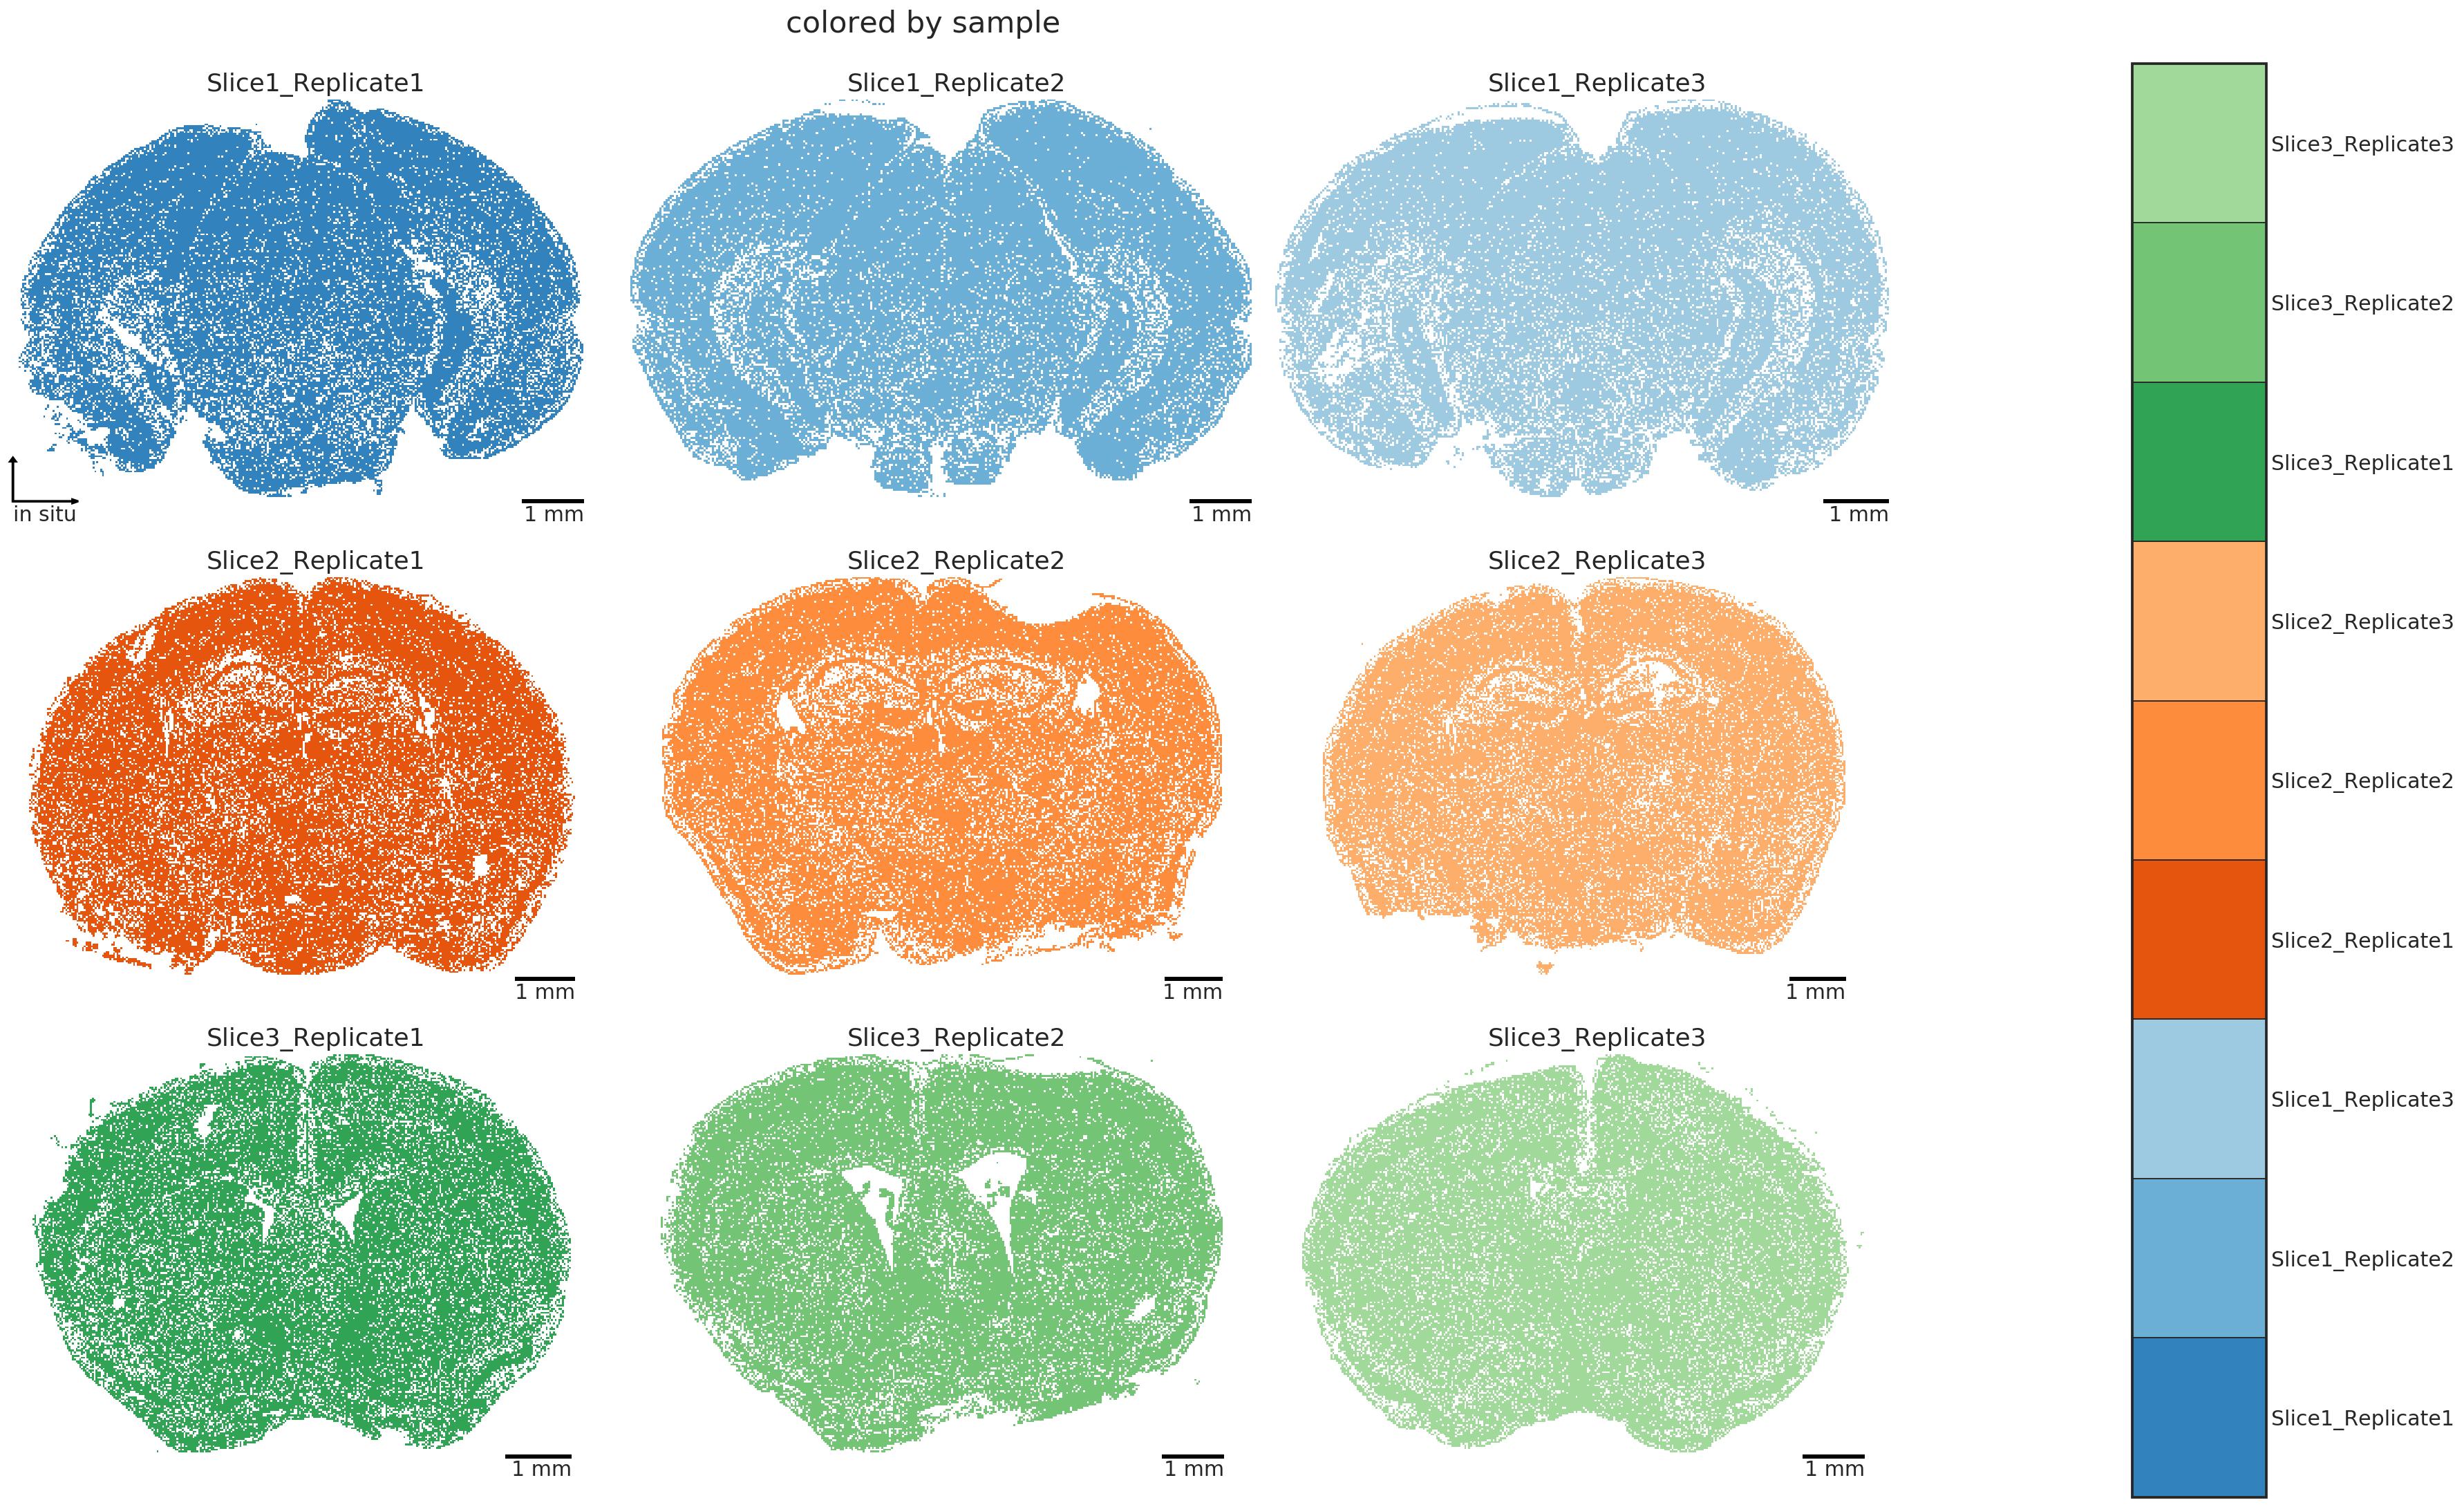

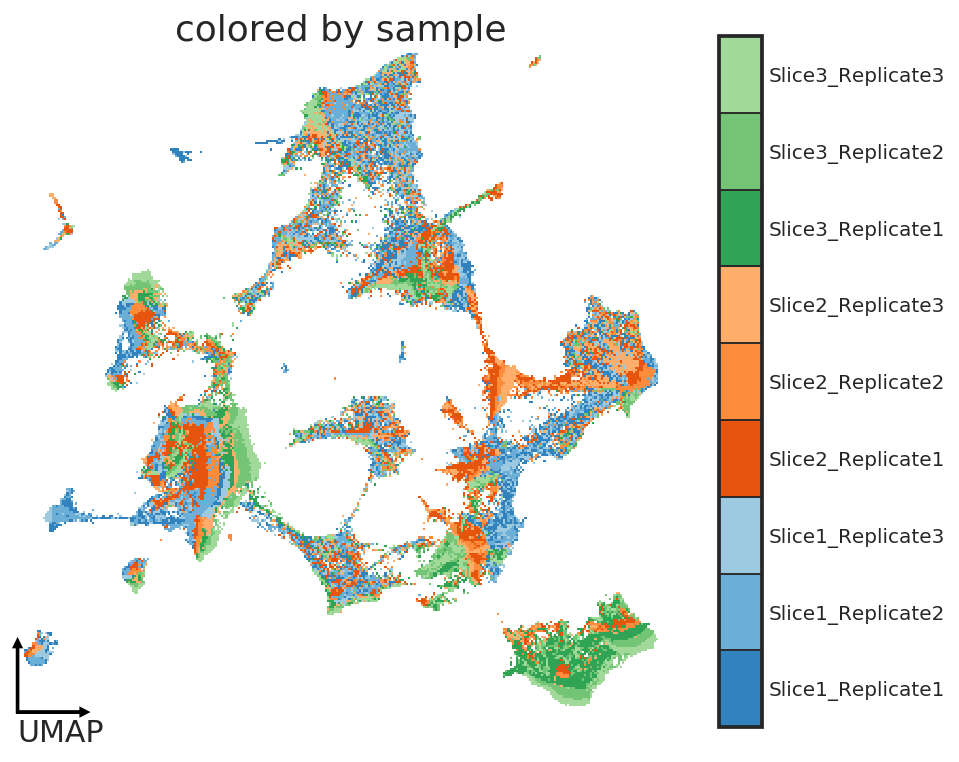

In [10]:
cat_col = 'sample_cat'
thedata[cat_col] = pd.Categorical(thedata['sample'])
categories = np.sort(thedata[cat_col].cat.categories.values)
clstcolors_obj = powerplot.CategoricalColors(categories, [palette[catg] for catg in categories])

# agg data for each sample
x, y, hue = 'x', 'y', cat_col
suptitle = 'colored by sample' 
output = figures.format("9slices_insitu_allclsts_"+cat_col+".png")
close = False
fig_plot_cluster_insitu_routine(
    thedata, samples, x, y, hue,
    clstcolors_obj,
    suptitle=suptitle,
    close=close,
    output=output, 
    ) 

# plot all clusters UMAP
x, y, hue = 'umap_1', 'umap_2', cat_col
title = 'colored by sample'
output = figures.format("9slices_umap_allclsts_"+cat_col+".png")
close = False
fig_plot_cluster_umap_routine(
    thedata, x, y, hue,
    clstcolors_obj,
    title=title,
    close=close,
    output=output,
    )

# C18 cluster

In [11]:
selecteddata = thedata[thedata['cluster_cat']=='C18']
print(selecteddata.shape)

(14340, 18)


In [12]:
selecteddata.groupby('sample').size()

sample
Slice1_Replicate1    3437
Slice1_Replicate2    3334
Slice1_Replicate3    3914
Slice2_Replicate1     870
Slice2_Replicate2    1337
Slice2_Replicate3    1441
Slice3_Replicate1       4
Slice3_Replicate2       2
Slice3_Replicate3       1
dtype: int64

In [13]:
cond = thedata['cluster_cat']=='C18'
diff = gmat.loc[cond].mean() - gmat.loc[~cond].mean()
diff_norm = diff/gmat.std()

In [14]:
gmat.loc[selecteddata.index].mean().sort_values(ascending=False).head(10)

Slc17a7    1.421512
Ntrk3      1.163222
Gabbr1     1.107120
Baiap2     1.094522
Epha4      1.000046
Grm5       0.980502
Cx3cl1     0.965500
Grin2b     0.961458
Gabbr2     0.910300
Epha7      0.881363
dtype: float64

In [15]:
diff.sort_values(ascending=False).head(10)

Slc17a7    0.762427
Ntrk3      0.608229
Epha7      0.596969
Baiap2     0.547288
Mas1       0.543719
Grm2       0.523390
Nrp1       0.468747
Epha4      0.466744
Chrm1      0.464612
Grin2b     0.461975
dtype: float64

In [16]:
diff_norm.sort_values(ascending=False).head(10)

Glp2r      2.836807
Mas1       2.657777
Npy2r      2.265166
Grm2       2.020030
Trhr       1.974860
Htr4       1.773504
Epha7      1.768748
Tmem108    1.683031
Nrp1       1.440643
Ntrk3      1.377714
dtype: float64

#### visualize with a heatmap 

In [19]:
samples_annot = {
    'Slice1_Replicate1': 'Slice1_R1',
    'Slice1_Replicate2': 'Slice1_R2',
    'Slice1_Replicate3': 'Slice1_R3',
    
    'Slice2_Replicate1': 'Slice2_R1',
    'Slice2_Replicate2': 'Slice2_R2',
    'Slice2_Replicate3': 'Slice2_R3',
    
    'Slice3_Replicate1': 'Slice3_R1',
    'Slice3_Replicate2': 'Slice3_R2',
    'Slice3_Replicate3': 'Slice3_R3',
}

In [33]:
# selecteddata
thedatagmat['sample_name'] = thedatagmat['sample'].apply(lambda x: samples_annot[x])
selecteddata = thedatagmat #[filter_cond]

# clusters present in all sections
selectedclusters = selecteddata.groupby(['cluster', 'sample_name']).size().unstack().dropna().index

# mean, std, n, zscore 
gmat_mean = selecteddata.groupby(['cluster', 'sample_name']).mean()[genes].loc[selectedclusters]
gmat_std = selecteddata.groupby(['cluster', 'sample_name']).std()[genes].loc[selectedclusters]
gmat_n = selecteddata.groupby(['cluster', 'sample_name']).count()[genes].loc[selectedclusters]
gmat_meanz = (gmat_mean - gmat_mean.mean())/gmat_mean.std()

# celltypes
celltypes = gmat_mean.index.levels[0].values

print(thedatagmat.shape, selecteddata.shape)
print(gmat_mean.shape, gmat_std.shape, gmat_n.shape, gmat_meanz.shape)

(692682, 501) (692682, 501)
(270, 483) (270, 483) (270, 483) (270, 483)


../figures/2021-07-13_gene_by_clusters_separate_samples.pdf


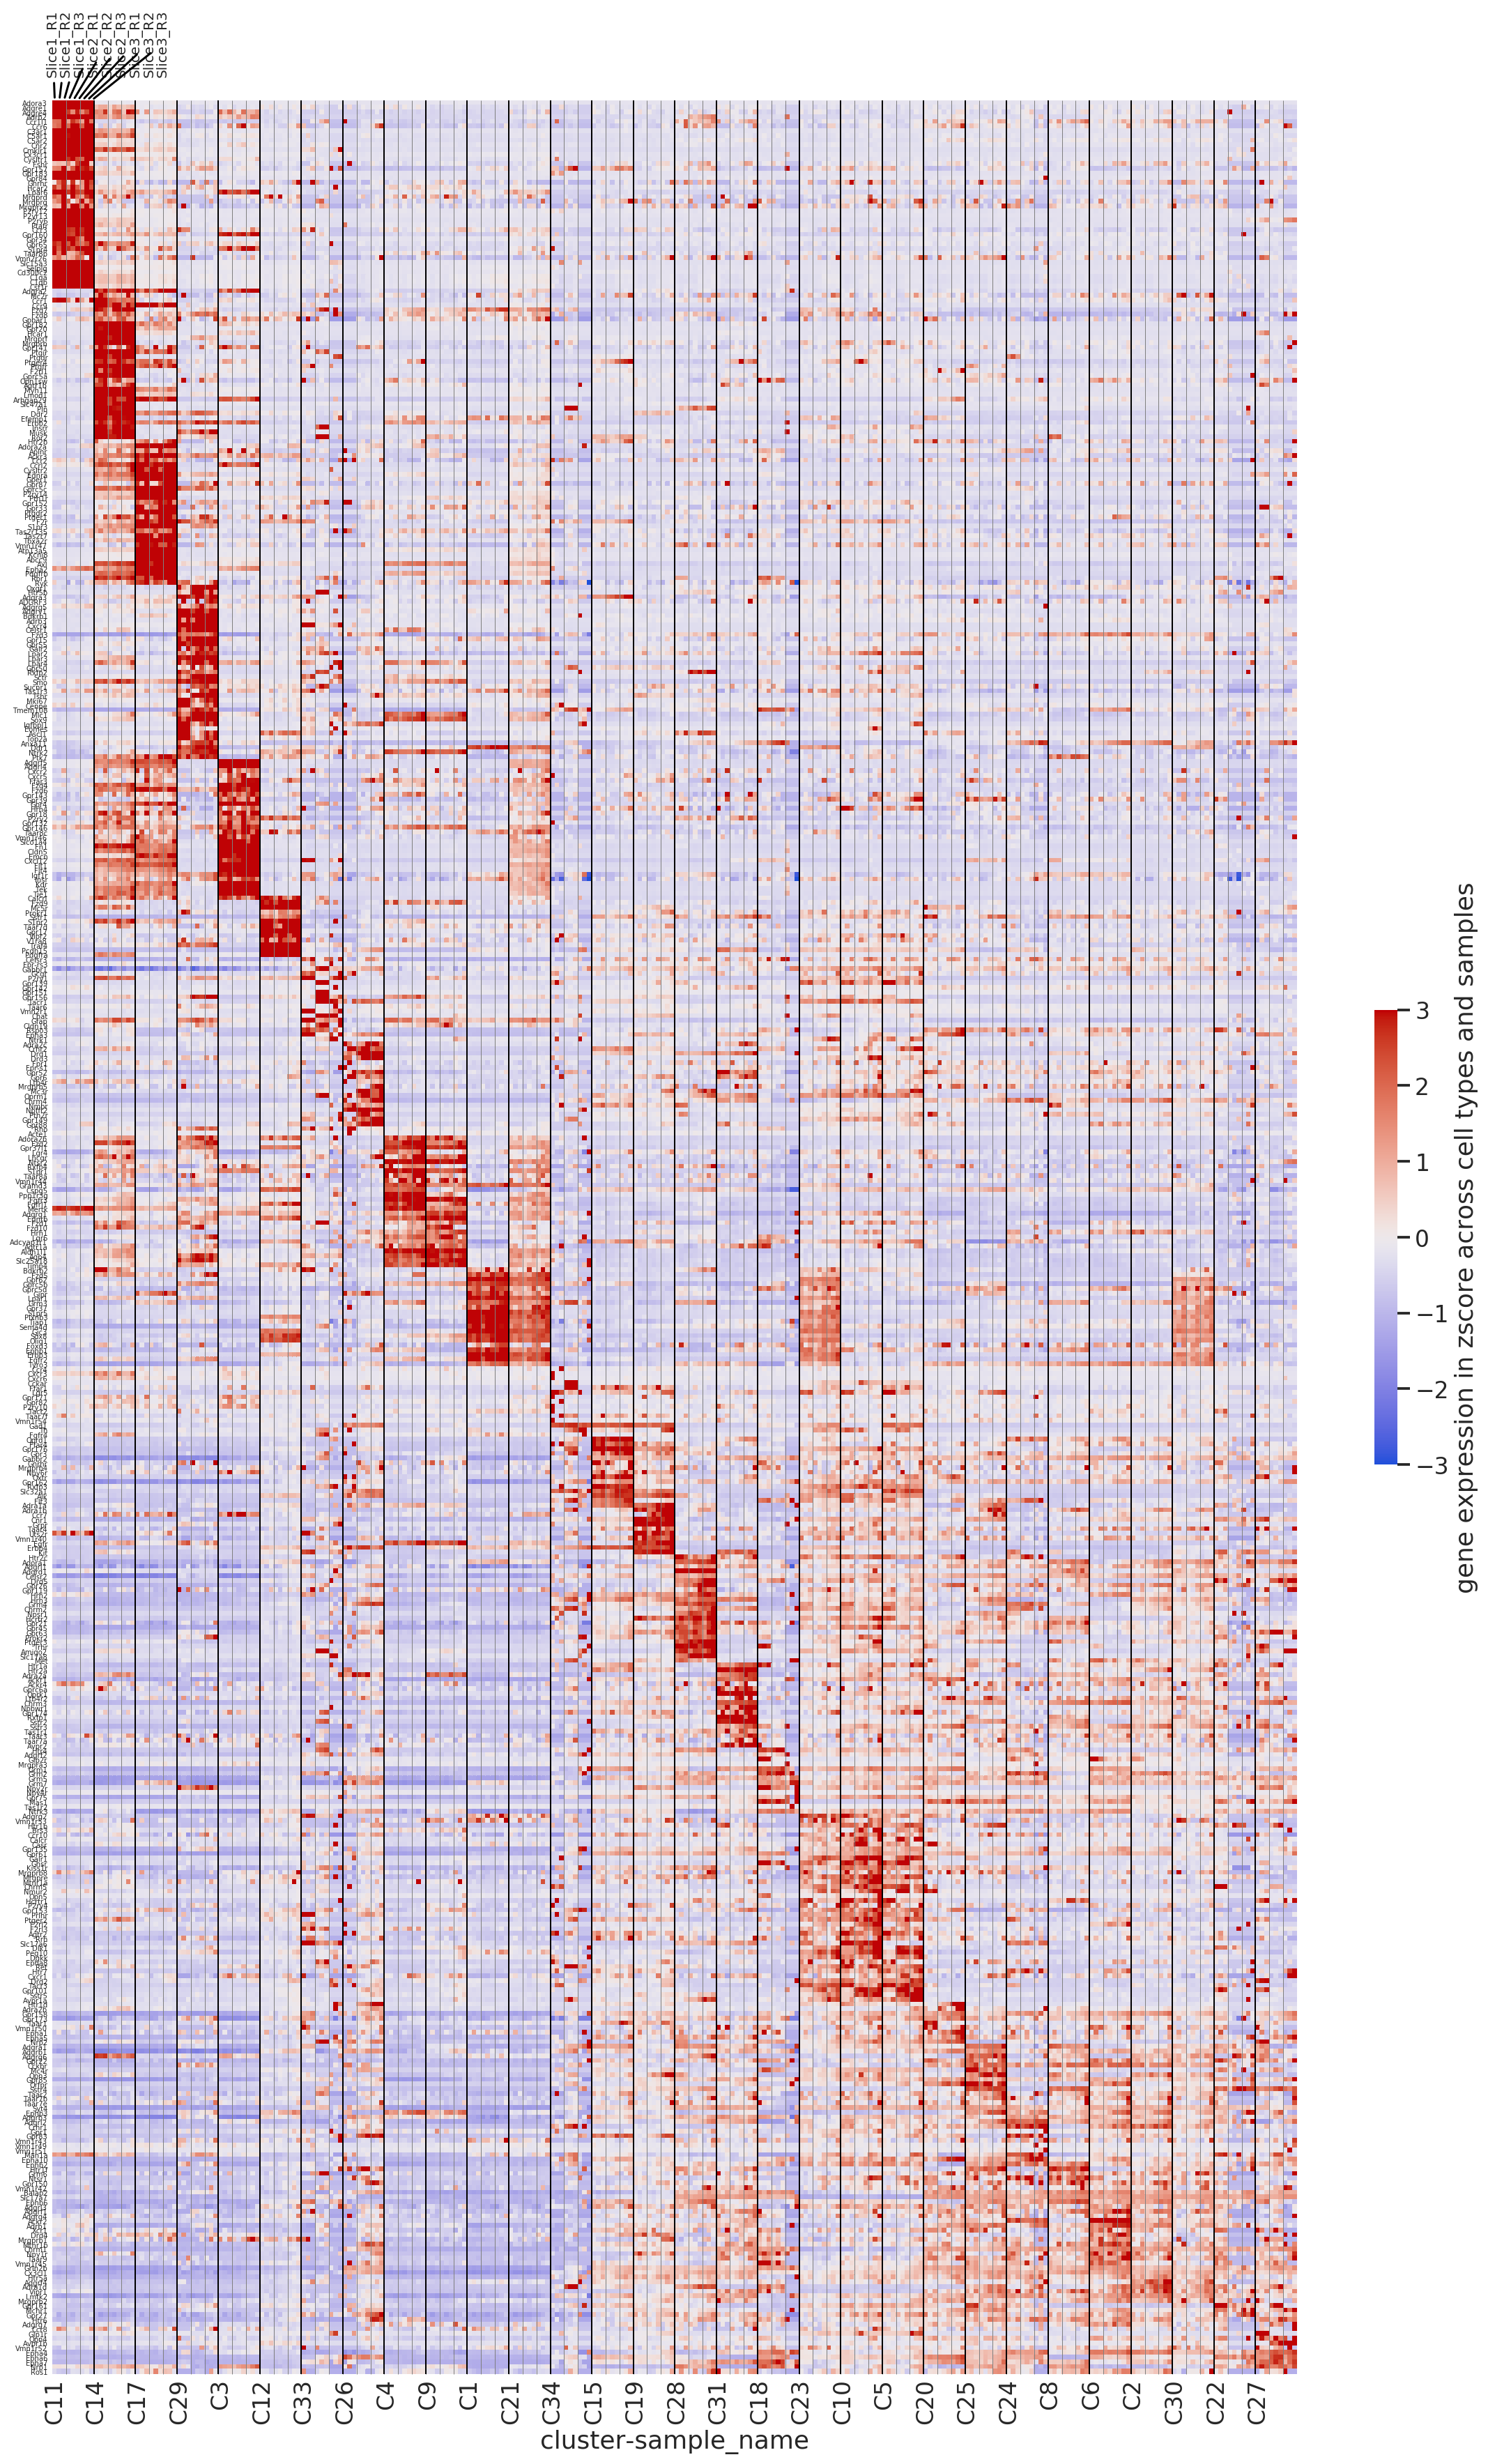

In [41]:
output = figures.format("gene_by_clusters_separate_samples.pdf")

heatmat = gmat_meanz.T

nrep = 9

heatmat_reduced = heatmat.mean(level=0, axis=1)
nrow, ncol = heatmat.shape

# order1 
_, rowidx, colidx_reduced = utils.diag_matrix(heatmat_reduced.values, threshold=1)
colidx = np.hstack([nrep*col+np.arange(nrep) for col in colidx_reduced])

# order2
row_order = utils.get_order_from_hierarchy(heatmat)
col_order_reduced = utils.get_order_from_hierarchy(heatmat_reduced.T) # by cluster; collapse slices
col_order = np.hstack([nrep*col+np.arange(nrep) for col in col_order_reduced])

# order3 (curated col_order_reduced)
_, rowidx_v3, _ = utils.diag_matrix_rows(heatmat_reduced.iloc[:,col_order_reduced].values)



../figures/2021-07-13_gene_by_clusters_separate_samples.pdf


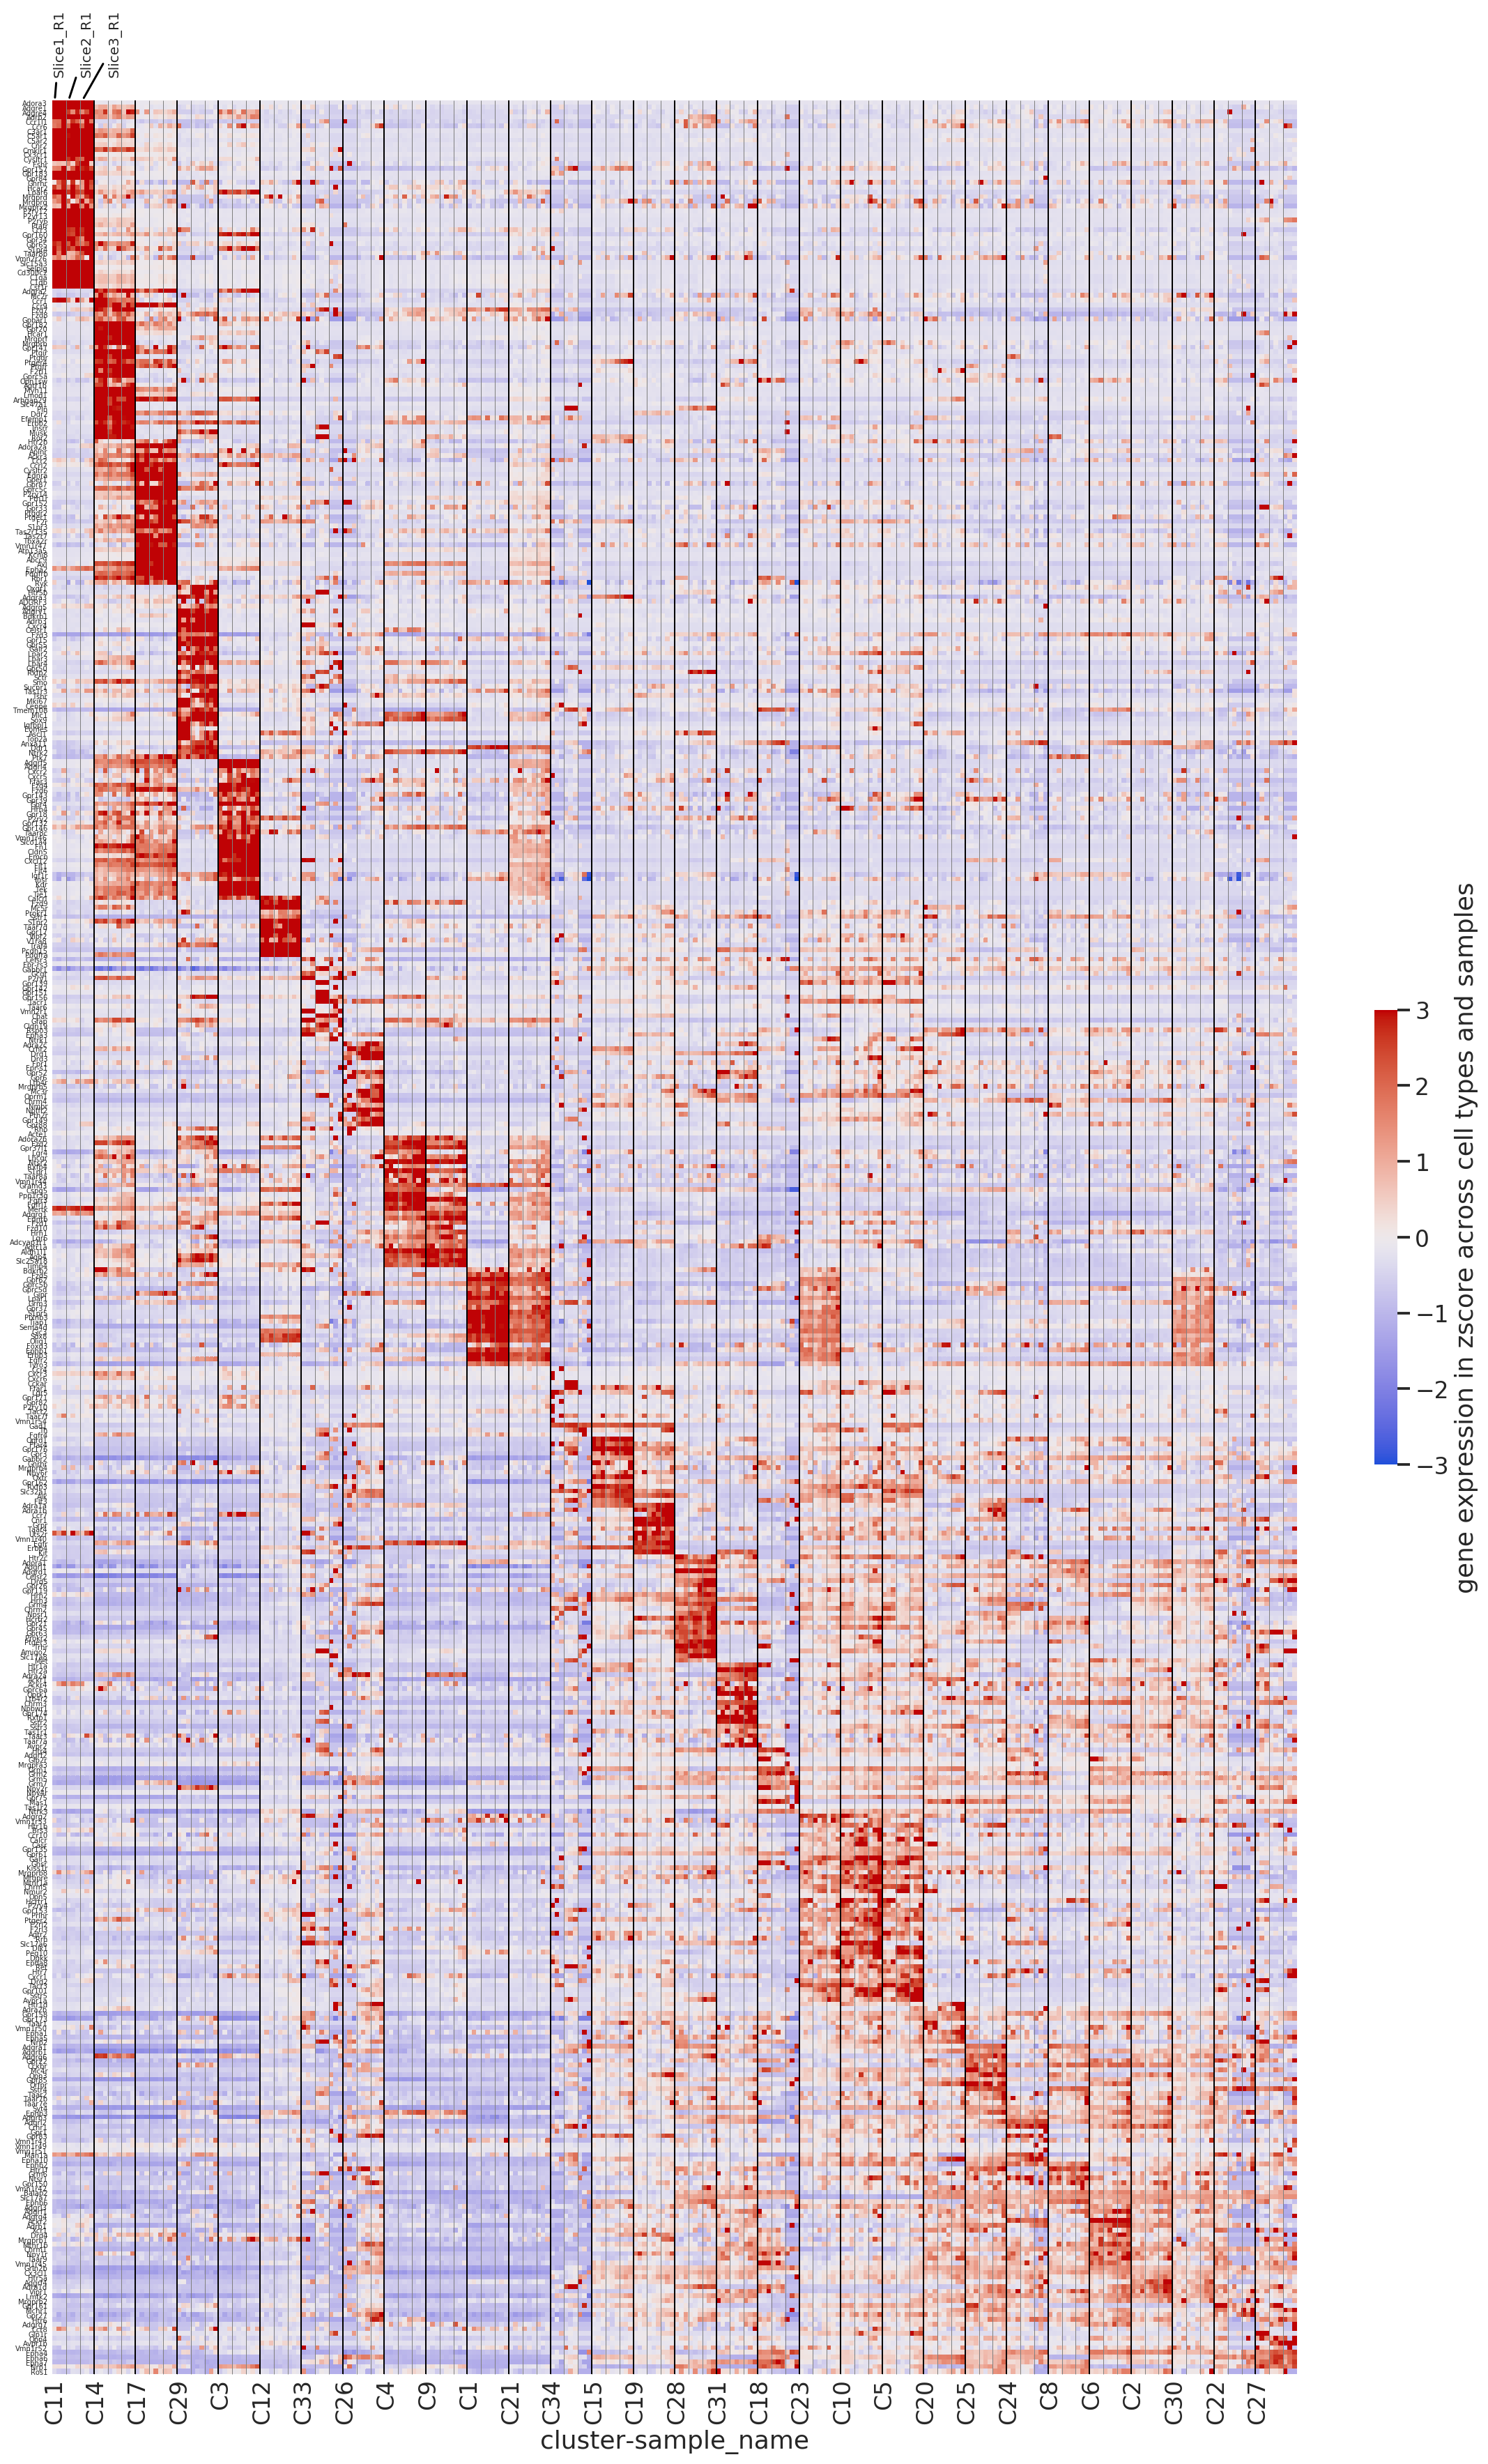

In [52]:
fig, ax = plt.subplots(figsize=(20, 30))
sns.heatmap(
#     heatmat.iloc[row_order, col_order], 
#     heatmat.iloc[rowidx, colidx], 
    heatmat.iloc[rowidx_v3, col_order], 
    vmax=3, vmin=-3, center=0, 
    xticklabels=True,
    yticklabels=True,
    cmap=colorcet.coolwarm,
    ax=ax,
    cbar_kws=dict(shrink=0.2, label='gene expression in zscore across cell types and samples'),
   )
ax.set_yticklabels(ax.get_yticklabels(), fontsize=5)
ax.tick_params(axis=u'both', which=u'both',length=0)

xtl = [tl.get_text() for tl in ax.get_xticklabels()]
xtl_part1 = [tl.split('-')[0] for tl in xtl]
xtl_part2 = ['-'.join(tl.split('-')[1:]) for tl in xtl]
xtl_simp = list(snmcseq_utils.dedup_array_elements(xtl_part1))
ax.set_xticklabels(xtl_simp)
for i in range(nrep): 
    if i % 3 == 0:
        ax.annotate(xtl_part2[i], 
                    xy=(i+0.5, 0), xytext=(2*i, -5), 
                    arrowprops=dict(arrowstyle='-', color='black'), 
                    va='bottom', 
                    ha='left',
                    rotation=90,
                    fontsize=10,
                   )

ax.vlines(np.arange(3, ncol, 3), 0, nrow, color='gray', linewidth=0.5, clip_on=False)
ax.vlines(np.arange(0, ncol, nrep)[1:], 0, nrow, color='black', linewidth=1, clip_on=False)

# utils.savefig(fig, output)
print(output)
plt.show()

cluster_orders = col_order_reduced

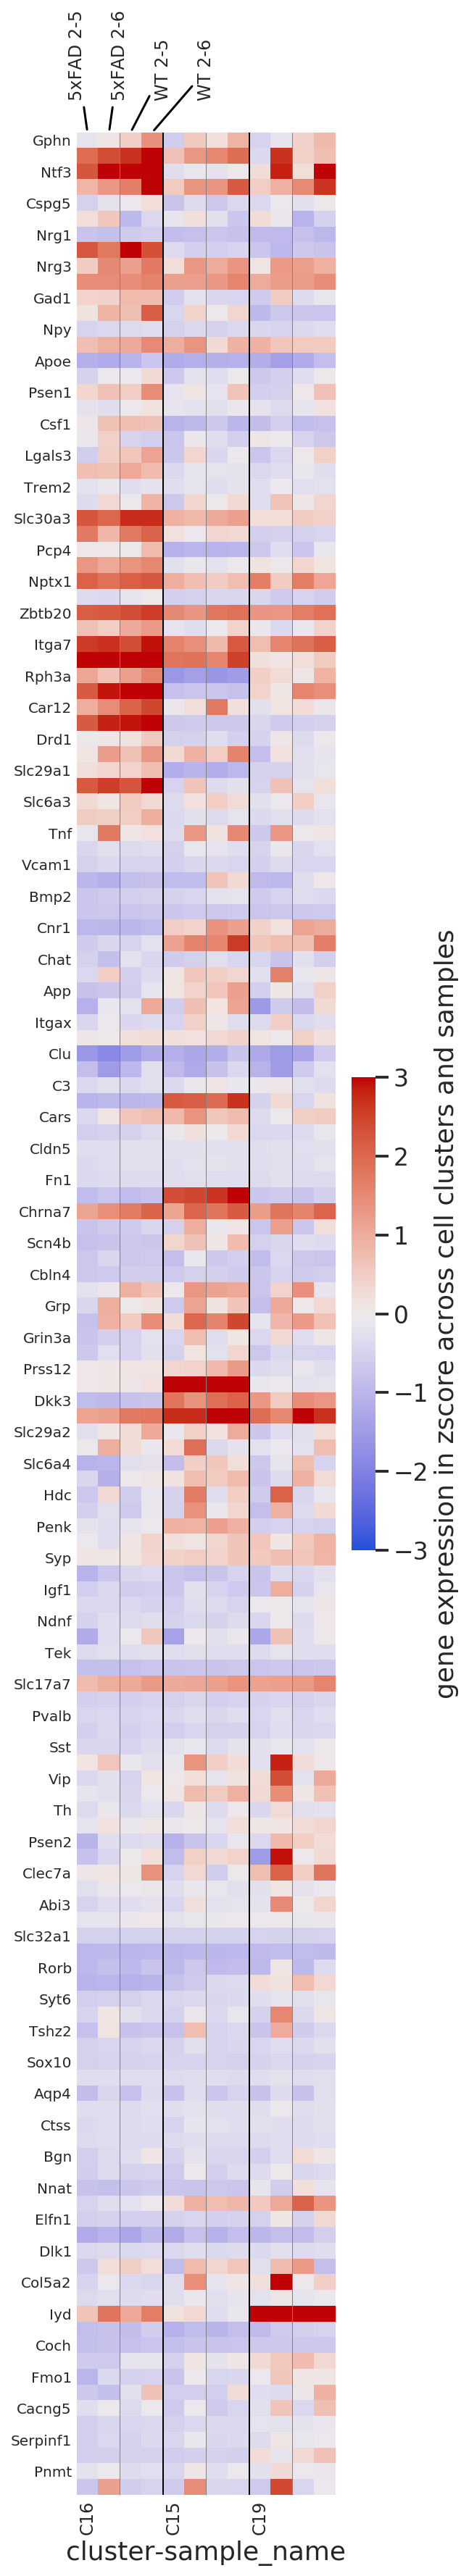

In [53]:
heatmat = gmat_meanz.loc[selected_clusters].T

heatmat_reduced = heatmat.mean(level=0, axis=1)
nrow, ncol = heatmat.shape

# order1 
_, rowidx, colidx_reduced = snmcseq_utils.diag_matrix(heatmat_reduced.values, threshold=1)
colidx = np.hstack([4*col+np.array([0,1,2,3]) for col in colidx_reduced])

# order2
row_order = utils.get_order_from_hierarchy(heatmat)
col_order_reduced = utils.get_order_from_hierarchy(heatmat_reduced.T) # by cluster; collapse slices
col_order = np.hstack([4*col+np.array([0,1,2,3]) for col in col_order_reduced])

# order3 (curated col_order_reduced)
_, rowidx_v3, _ = utils.diag_matrix_rows(heatmat_reduced.iloc[:,col_order_reduced].values)

fig, ax = plt.subplots(figsize=(4, 30))
sns.heatmap(
#     heatmat.iloc[row_order, col_order],
#     heatmat.iloc[rowidx, colidx],
    heatmat.iloc[rowidx_v3, col_order], 
    vmax=3, vmin=-3, center=0, 
    xticklabels=True,
    cmap=colorcet.coolwarm,
    cbar_kws=dict(shrink=0.2, label='gene expression in zscore across cell clusters and samples'),
    ax=ax,
   )
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.tick_params(axis=u'both', which=u'both',length=0)

xtl = [tl.get_text() for tl in ax.get_xticklabels()]
xtl_part1 = [tl.split('-')[0] for tl in xtl]
xtl_part2 = ['-'.join(tl.split('-')[1:]) for tl in xtl]
xtl_simp = list(snmcseq_utils.dedup_array_elements(xtl_part1))
ax.set_xticklabels(xtl_simp, fontsize=12)
for i in range(4): 
    ax.annotate(xtl_part2[i], 
                (i+0.5, 0), (2*i, -2), 
                arrowprops=dict(arrowstyle='-', color='black'), 
                va='bottom', 
                ha='center',
                rotation=90,
                fontsize=12,
               )


ax.vlines(np.arange(0, ncol, 4)[1:], 0, nrow, color='black', linewidth=1, clip_on=False)
ax.vlines(np.arange(2, ncol, 4), 0, nrow, color='gray', linewidth=0.5, clip_on=False)
plt.show()